# IEEE Fraud Detection with CatBoost

For more explanation on CatBoost, readers may refer to https://catboost.ai/

## Table of contents
* [1. Pre-processing](#pre-processing)
* [2. Explore data](#explore)
* [3. Training or fitting model](#training)
* [4. Predicting](#testing)


In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# 1. Data pre-processing <a name="pre-processing"></a>

Training data is loaded and explore. Training data contain Transaction and identity which are needed to be merged. In the training data there are many columns contain missing values. Dealing with missing values is quite challenging. In this work, we will drop them out of consideration. 

### Loding training data 

In [69]:
df_tr_data = pd.read_csv('dataset/train_transaction.csv')
df_tr_id_data = pd.read_csv('dataset/train_identity.csv')

df_te_data = pd.read_csv('dataset/test_transaction.csv')
df_te_id_data = pd.read_csv('dataset/test_identity.csv')

In [70]:
print('Size of training transaction: ', df_tr_data.shape)
print('Size of training identity: ', df_tr_id_data.shape)

print('Size of testing transaction: ', df_te_data.shape)
print('Size of testing identity: ', df_te_id_data.shape)

Size of training transaction:  (590540, 394)
Size of training identity:  (144233, 41)
Size of testing transaction:  (506691, 393)
Size of testing identity:  (141907, 41)


In [128]:
df_tr = pd.merge(df_tr_data, df_tr_id_data, on='TransactionID', how='left')
df_te = pd.merge(df_te_data, df_te_id_data, on='TransactionID', how='left')
print('Size of training data: ', df_tr.shape)
print('Size of testing data: ', df_te.shape)

Size of training data:  (590540, 434)
Size of testing data:  (506691, 433)


In [129]:
df_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [130]:
df_te.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Using visualization techniques to explore data <a name="explore"></a>

In [131]:
df_g_f = (df_tr.groupby(['isFraud']).size().reset_index(name='COUNT'))
print('Number of fraud record is ', df_g_f.iloc[0,1])
print('Number of nonfraud record is ', df_g_f.iloc[1,1])
print('The ratio is ', df_g_f.iloc[1,1]/df_g_f.iloc[0,1]*100, ' %')

Number of fraud record is  569877
Number of nonfraud record is  20663
The ratio is  3.625870143908247  %


In [132]:
df_g_t = (df_tr.groupby(['ProductCD']).size().reset_index(name='COUNT'))
df_g_t

,ProductCD,COUNT
0,C,68519
1,H,33024
2,R,37699
3,S,11628
4,W,439670


,card6,COUNT
0,charge card,15
1,credit,148986
2,debit,439938
3,debit or credit,30


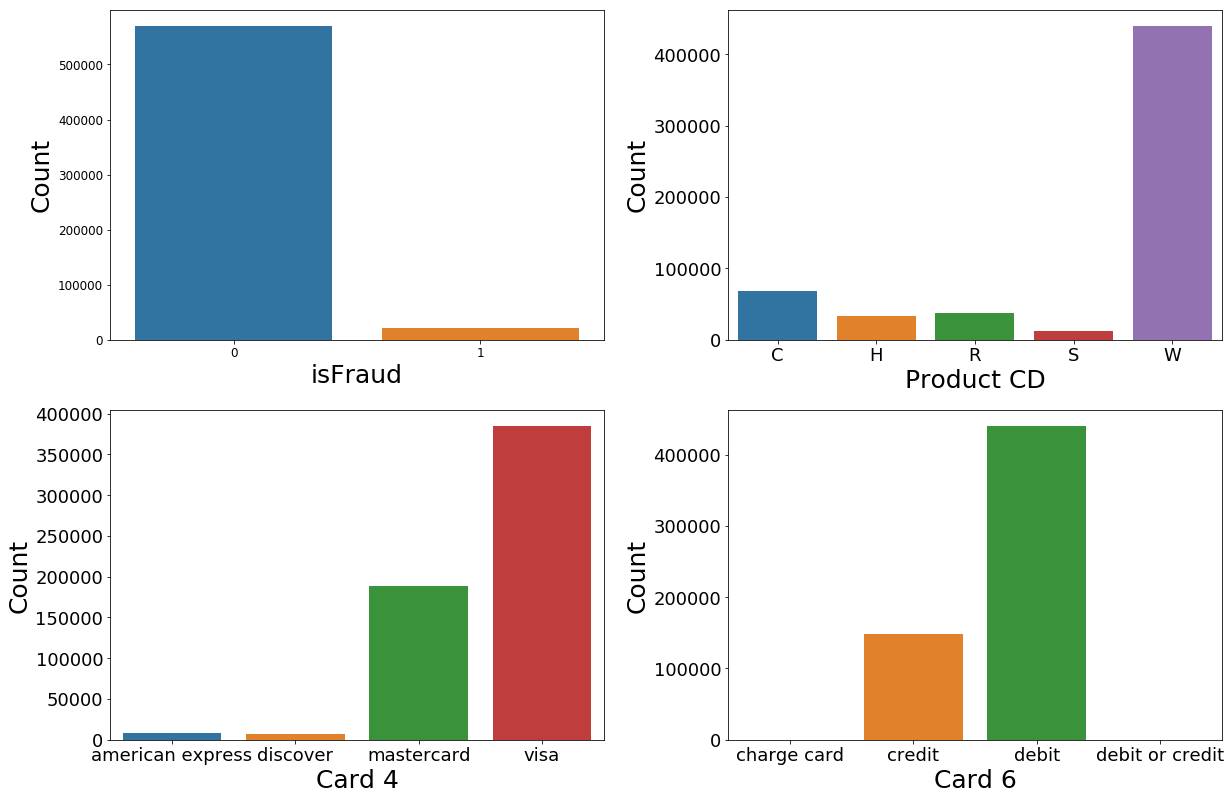

In [133]:
f, axes = plt.subplots(2,2, figsize=(17, 11), sharex=False, constrained_layout=True)

df_g_f = df_g_f.sort_values(by='COUNT', ascending=False)
bar = sns.barplot(y="COUNT", x="isFraud", data=df_g_f, ax=axes[0,0])
bar.set_ylabel("Count",fontsize=25)
bar.set_xlabel("isFraud",fontsize=25)
bar.tick_params(labelsize=12)

bar = sns.barplot(y="COUNT", x="ProductCD", data=df_g_t, ax=axes[0,1])
bar.set_ylabel("Count",fontsize=25)
bar.set_xlabel("Product CD",fontsize=25)
bar.tick_params(labelsize=18)

df_g_c4 = (df_tr.groupby(['card4']).size().reset_index(name='COUNT'))
bar = sns.barplot(x="card4", y="COUNT", data=df_g_c4, ax=axes[1,0])
bar.set_ylabel("Count",fontsize=25)
bar.set_xlabel("Card 4",fontsize=25)
bar.tick_params(labelsize=18)

df_g_c6 = (df_tr.groupby(['card6']).size().reset_index(name='COUNT'))
bar = sns.barplot(x="card6", y="COUNT", data=df_g_c6, ax=axes[1,1])
bar.set_ylabel("Count",fontsize=25)
bar.set_xlabel("Card 6",fontsize=25)
bar.tick_params(labelsize=18)
df_g_c6

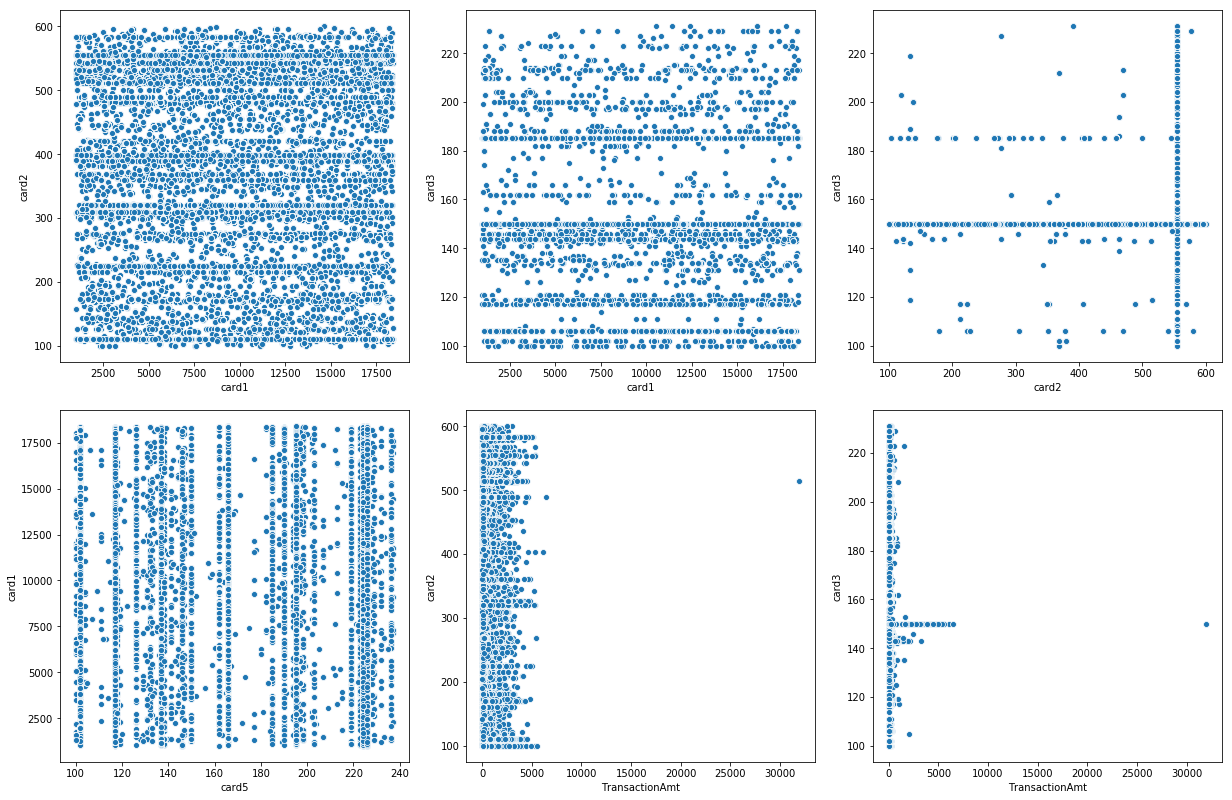

In [134]:
f, axes = plt.subplots(2,3, figsize=(17, 11), sharex=False, constrained_layout=True)

sns.scatterplot(x="card1", y="card2", data=df_tr, ax = axes[0,0])
sns.scatterplot(x="card1", y="card3", data=df_tr, ax = axes[0,1])
sns.scatterplot(x="card2", y="card3", data=df_tr, ax = axes[0,2])
sns.scatterplot(x="card5", y="card1", data=df_tr, ax = axes[1,0])
sns.scatterplot(x="TransactionAmt", y="card2", data=df_tr, ax = axes[1,1])
sns.scatterplot(x="TransactionAmt", y="card3", data=df_tr, ax = axes[1,2])

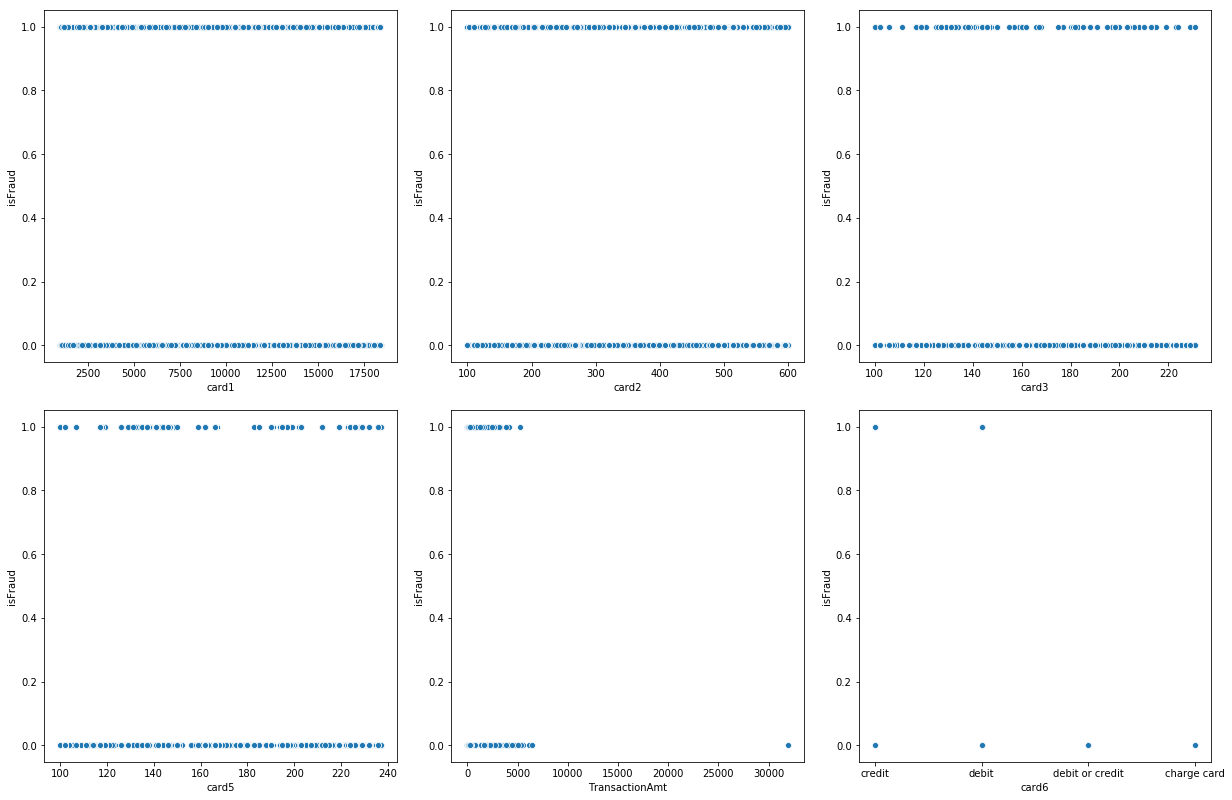

In [135]:
f, axes = plt.subplots(2,3, figsize=(17, 11), sharex=False, constrained_layout=True)

sns.scatterplot(x="card1", y="isFraud", data=df_tr, ax = axes[0,0])
sns.scatterplot(x="card2", y="isFraud", data=df_tr, ax = axes[0,1])
sns.scatterplot(x="card3", y="isFraud", data=df_tr, ax = axes[0,2])
sns.scatterplot(x="card5", y="isFraud", data=df_tr, ax = axes[1,0])
sns.scatterplot(x="TransactionAmt", y="isFraud", data=df_tr, ax = axes[1,1])
sns.scatterplot(x="card6", y="isFraud", data=df_tr, ax = axes[1,2])

In [136]:
null = df_tr.isnull().sum()/df_tr.shape[0]*100
cols_to_drop = np.array(null[null > 20].index)
cols_to_drop

array(['dist1', 'dist2', 'R_emaildomain', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3',
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5',
       'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V35', 'V36', 'V37', 'V38',
       'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47',
       'V48', 'V49', 'V50', 'V51', 'V52', 'V138', 'V139', 'V140', 'V141',
       'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149',
       'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157',
       'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165',
       'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173',
       'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181',
       'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189',
       'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197',
       'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205',

In [137]:
# Taking the 'isFraud' out as it is label column
labels = df_tr['isFraud']
df_tr.drop(columns=['isFraud'], inplace=True)
df_tr.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


#### Column that containing missing values up to 20% will be left out. 

In [138]:
df_tr.drop(cols_to_drop, axis=1, inplace=True)
df_te.drop(cols_to_drop, axis=1, inplace=True)

In [139]:
#Replacing missing values with modes

null_cols = df_tr.columns.values

for i in null_cols:
    df_tr[i] = df_tr[i].replace(np.nan, df_tr[i].mode()[0])
    df_te[i] = df_te[i].replace(np.nan, df_te[i].mode()[0])

In [140]:
# Checking the dimensions of the training, testing and label variables
print(df_tr.shape)
print(labels.shape)
print(df_te.shape)

(590540, 181)
(590540,)
(506691, 181)


In [141]:
# Checking if there are still missing values
null_percent = df_tr.isnull().sum()
null_percent[null_percent > 0]

Series([], dtype: int64)

In [142]:
df_tr.columns.values

array(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1',
       'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
       'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'D15',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74',
       'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
       'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92',
       'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101',
       'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109',
       'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117',
     

In [143]:
df_te.columns.values

array(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1',
       'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7',
       'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D10', 'D15',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29',
       'V30', 'V31', 'V32', 'V33', 'V34', 'V53', 'V54', 'V55', 'V56',
       'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65',
       'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74',
       'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83',
       'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92',
       'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101',
       'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109',
       'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117',
     

After some columns are removed, we can still see some rows contain missing values. We will remove them too.

##### Column card6 contains four type of values which are 'charge card', 'credit', 'debit', and 'debit or credit'. There are only 3 rows contains 'charge card' and there are 30 records contain 'debit or credit'. Moreover, in the testing data there contain no values of these two types after some columns are removed. Hence we decide to remove them. 

In [144]:
indexCard6_1 = df_tr[df_tr['card6'] == 'charge card'].index
indexCard6_2 = df_tr[df_tr['card6'] == 'debit or credit'].index
print(indexCard6_1)
print(indexCard6_2)
#Delete these row indexes from dataFrame
if len(indexCard6_1)>0:
    df_tr.drop(indexCard6_1 , inplace=True)
    labels.drop(indexCard6_1 , inplace=True)
if len(indexCard6_2)>0:
    df_tr.drop(indexCard6_2 , inplace=True)
    labels.drop(indexCard6_2 , inplace=True)


indexCard6Te_1 = df_te[df_te['card6'] == 'charge card'].index
indexCard6Te_2 = df_te[df_te['card6'] == 'debit or credit'].index
# Delete these row indexes from dataFrame
if len(indexCard6Te_1)>0:
    df_te.drop(indexCard6Te_1 , inplace=True)
if len(indexCard6Te_2)>0:
    df_te.drop(indexCard6Te_2 , inplace=True)


Int64Index([ 23523,  47201,  47306, 106355, 132025, 155948, 164729, 166714,
            185040, 199382, 205426, 252196, 367099, 381355, 381382],
           dtype='int64')
Int64Index([ 16408,  27859,  43216,  54633,  61895,  67872,  81130, 110482,
            134726, 137320, 197640, 201487, 215877, 219394, 225017, 256701,
            259306, 311483, 322832, 322886, 331989, 340607, 347948, 365860,
            376300, 384002, 392900, 396390, 396405, 416148],
           dtype='int64')


In [168]:
if('isFraud' in df_tr.columns.values):
    df_tr.drop(columns=['isFraud'], inplace=True)

print(df_tr.shape)
print(labels.shape)
print(df_te.shape)

(590495, 186)
(590495,)
(506690, 186)


#### Convert categorical variables to dummy variables since our model does not work with categorical variables. 

In [146]:
productCD = pd.get_dummies(df_tr['ProductCD'])
df_tr.drop(columns=['ProductCD'], inplace=True)
df_tr = pd.concat([df_tr, productCD], axis=1)

productCD = pd.get_dummies(df_te['ProductCD'])
df_te.drop(columns=['ProductCD'], inplace=True)
df_te = pd.concat([df_te, productCD], axis=1)

In [147]:
card4 = pd.get_dummies(df_tr['card4'])
df_tr.drop(columns=['card4'], inplace=True)
df_tr = pd.concat([df_tr, card4], axis=1)

card4 = pd.get_dummies(df_te['card4'])
df_te.drop(columns=['card4'], inplace=True)
df_te = pd.concat([df_te, card4], axis=1)

In [148]:
card6 = pd.get_dummies(df_tr['card6'])
df_tr.drop(columns=['card6'], inplace=True)
df_tr = pd.concat([df_tr, card6], axis=1)

card6 = pd.get_dummies(df_te['card6'])
df_te.drop(columns=['card6'], inplace=True)
df_te = pd.concat([df_te, card6], axis=1)

In [149]:
df_tr.drop(columns=['P_emaildomain'], inplace=True)
df_te.drop(columns=['P_emaildomain'], inplace=True)

In [150]:
df_tr.drop(columns=['TransactionID','TransactionDT'], inplace=True)
df_te.drop(columns=['TransactionID','TransactionDT'], inplace=True)

#### Plot correlation matrix of the variables

In [151]:
co_mat = df_tr.corr()

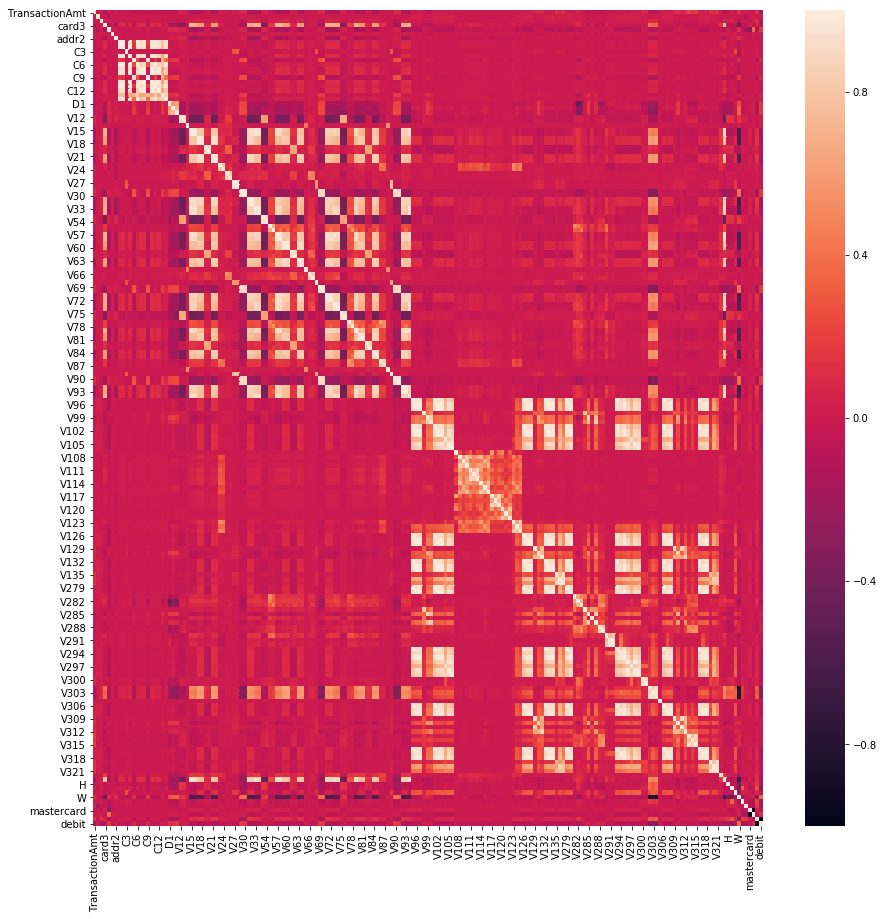

In [152]:
plt.figure(figsize=(15,15))
sns.heatmap(co_mat)

### Deviding the data into training and validation sets

In [169]:
X_data = df_tr.values
y_data = labels.values

In [170]:
# Splitting the data into training and testing set
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.10, random_state=1)

# 3. Fitting or learning using CateBoost <a name="training"></a>

In [155]:
from catboost import CatBoostClassifier, Pool

In [171]:
eval_dataset = Pool(X_val, y_val)

model = CatBoostClassifier(iterations=1000, learning_rate=0.1, eval_metric='AUC')


In [172]:
model.fit(X_train, y_train, 
                            eval_set=eval_dataset, 
                            verbose=1000,
                            early_stopping_rounds=1000,
                            plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7253541	best: 0.7253541 (0)	total: 129ms	remaining: 2m 8s
999:	test: 0.9213407	best: 0.9213407 (999)	total: 2m 18s	remaining: 0us

bestTest = 0.9213407463
bestIteration = 999



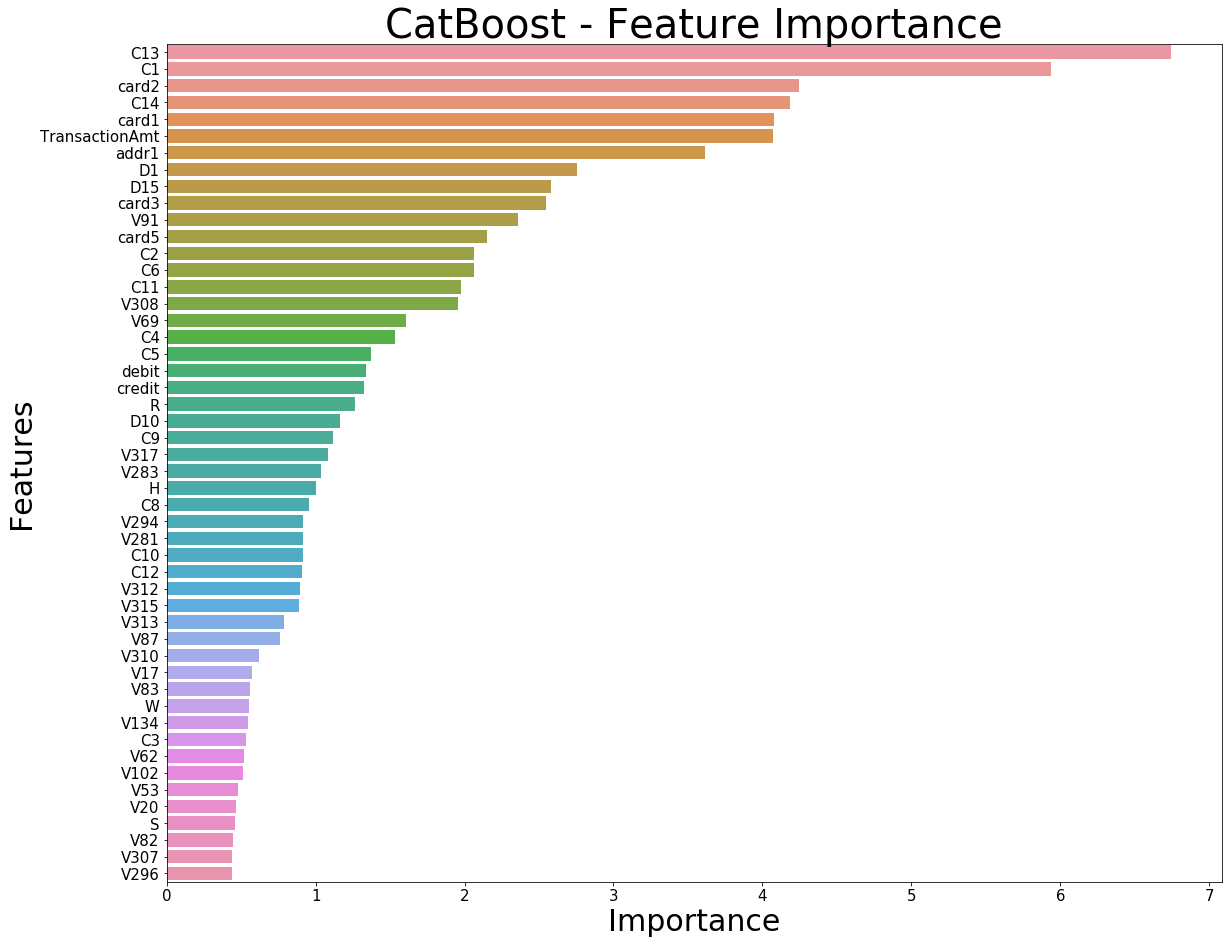

In [173]:
f, axes = plt.subplots(1,1, figsize=(17, 13), sharex=False, constrained_layout=True)
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': df_tr.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[False, False]).iloc[0:50]
bar = sns.barplot(y='col', x='imp', data=fea_imp)
bar.axes.set_title('CatBoost - Feature Importance',fontsize=40)
bar.set_ylabel('Features',fontsize=30)
bar.set_xlabel('Importance',fontsize=30);
bar.tick_params(labelsize=15)

In [174]:
preds_class = model.predict_proba(X_val)

In [175]:
# Computing the AUC based on the validation set
fpr, tpr, thresholds = metrics.roc_curve(y_val, preds_class[:,1], pos_label=1)
print('Catboost AUC = ', metrics.auc(fpr, tpr))

Catboost AUC =  0.921340746271958


# 4. Predicting on test data<a name="testing"></a>

In [176]:
y_pred_te = model.predict_proba(df_te)

In [177]:
submit = pd.read_csv('dataset/sample_submission.csv')

In [178]:
#submit[['isFraud']]=y_pred_te[:,1]
y_pred_te = pd.DataFrame(y_pred_te)
submit[['isFraud']]=y_pred_te.iloc[:,1]

In [179]:
submit.to_csv('submit_prediction.csv',index=False)

In [118]:
#m6 = pd.get_dummies(df_tr['M6'])
#df_tr.drop(columns=['M6'], inplace=True)
#df_tr = pd.concat([df_tr, m6], axis=1)

#m6 = pd.get_dummies(df_te['M6'])
#df_te.drop(columns=['M6'], inplace=True)
#df_te = pd.concat([df_te, m6], axis=1)